## Testing the non-filtering approach (excluding the TR filter)

In [ ]:
import os
import numpy as np
import pandas as pd
from nilearn import connectome
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
base_1d_files_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200/'
derivative_name = 'rois_cc200'

all_filenames_in_dir = os.listdir(base_1d_files_path)

available_file_ids = set()
for filename in all_filenames_in_dir:
    if filename.endswith(f"_{derivative_name}.1D"):
        file_id = filename.replace(f"_{derivative_name}.1D", "")
        available_file_ids.add(file_id)

pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
pheno_df_full = pd.read_csv(pheno_file_path)
pheno_df_full = pheno_df_full[pheno_df_full['FILE_ID'] != 'no_filename']

pheno_df_filtered = pheno_df_full[pheno_df_full['FILE_ID'].isin(available_file_ids)].copy()

# DX_GROUP: 1 is ASD, 2 is TD.
pheno_df_filtered['label'] = pheno_df_filtered['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
# --- Defining the time_series without TR count restriction ---

def load_timeseries_revised(file_path):
    """Loads a .1D file into a NumPy array with a minimum TR check."""
    try:
        timeseries = np.loadtxt(file_path)

        if timeseries.size == 0:
            print(f"DEBUG load_timeseries: Loaded empty data from {file_path}.")
            return None
        if timeseries.ndim == 0:
            print(f"DEBUG load_timeseries: Loaded scalar data from {file_path}. Shape: {timeseries.shape}")
            return None


        if timeseries.ndim != 2 or timeseries.shape[1] != 200:
            print(f"DEBUG load_timeseries: Problematic dimensions/ROI count. Shape: {timeseries.shape} for {file_path}")
            return None


        return timeseries
    except Exception as e:
        print(f"DEBUG load_timeseries: Error loading {file_path} with np.loadtxt: {e}")
        return None

In [ ]:
connectivity_measure = connectome.ConnectivityMeasure(kind='correlation', vectorize=False)

all_fc_matrices_revised = []
subject_ids_for_model_revised = []
labels_for_model_revised = []

successfully_processed_count_revised = 0


for index, row in pheno_df_filtered.iterrows():
    file_id = row['FILE_ID']
    label = row['label']
    subject_file_path = os.path.join(base_1d_files_path, f"{file_id}_{derivative_name}.1D")

    timeseries = load_timeseries_revised(subject_file_path)

    if timeseries is None:
        continue

    try:
        fc_matrix = connectivity_measure.fit_transform([timeseries])[0]
        all_fc_matrices_revised.append(fc_matrix)
        subject_ids_for_model_revised.append(file_id)
        labels_for_model_revised.append(label)
        successfully_processed_count_revised +=1
    except Exception as e:
        print(f"ERROR during FC calculation for {file_id}: {e}")


print("\n--- Revised Data Processing Summary ---")
print(f"Total subjects initially available (found .1D files): {len(pheno_df_filtered)}")
print(f"Successfully processed for FC (final): {successfully_processed_count_revised}")

if successfully_processed_count_revised > 0:
    all_fc_matrices_final = np.array(all_fc_matrices_revised)
    y_final = np.array(labels_for_model_revised)
    print(f"Shape of final X (FC matrices collection): {all_fc_matrices_final.shape}")
else:
    print("No subjects passed the revised processing criteria.")


--- Revised Data Processing Summary ---
Total subjects initially available (found .1D files): 884
Successfully processed for FC (final): 884
Shape of final X (FC matrices collection): (884, 200, 200)


In [ ]:
n_subjects = all_fc_matrices_final.shape[0]
n_rois = all_fc_matrices_final.shape[1]

# Get the indices for the upper triangle, excluding the diagonal (k=1)
triu_indices = np.triu_indices(n_rois, k=1)

# to store the flattened feature vectors
X_flattened_list = []

for i in range(n_subjects):
    fc_matrix = all_fc_matrices_final[i]
    flattened_vector = fc_matrix[triu_indices]
    X_flattened_list.append(flattened_vector)

# Convert the list of flattened vectors into a 2D NumPy array
X_for_ml = np.array(X_flattened_list)
y_for_ml = y_final

print(f"Shape of feature matrix X_for_ml: {X_for_ml.shape}")
# For 200 ROIs, N_unique_connections = (200 * 199) / 2 = 19900
print(f"Shape of label vector y_for_ml: {y_for_ml.shape}")

Shape of feature matrix X_for_ml: (884, 19900)
Shape of label vector y_for_ml: (884,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_for_ml, y_for_ml, test_size=0.2, random_state=42, stratify=y_for_ml
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw) # Use transform only on test data

print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

Shape of X_train_scaled: (707, 19900)
Shape of X_test_scaled: (177, 19900)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001,0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000), param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_log_reg = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(
    penalty='l2', C=0.001, solver='liblinear', random_state=42, max_iter=3000
)# L2 regularization is used for prenalty
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


--- Model Performance Evaluation ---

Accuracy: 0.6780

Confusion Matrix:
[[64 31]
 [26 56]]


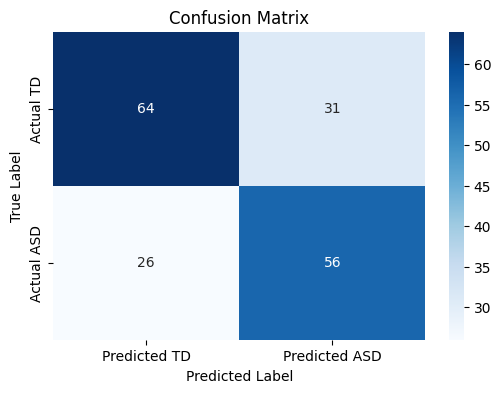


Classification Report:
              precision    recall  f1-score   support

          TD       0.71      0.67      0.69        95
         ASD       0.64      0.68      0.66        82

    accuracy                           0.68       177
   macro avg       0.68      0.68      0.68       177
weighted avg       0.68      0.68      0.68       177


ROC AUC Score: 0.7530


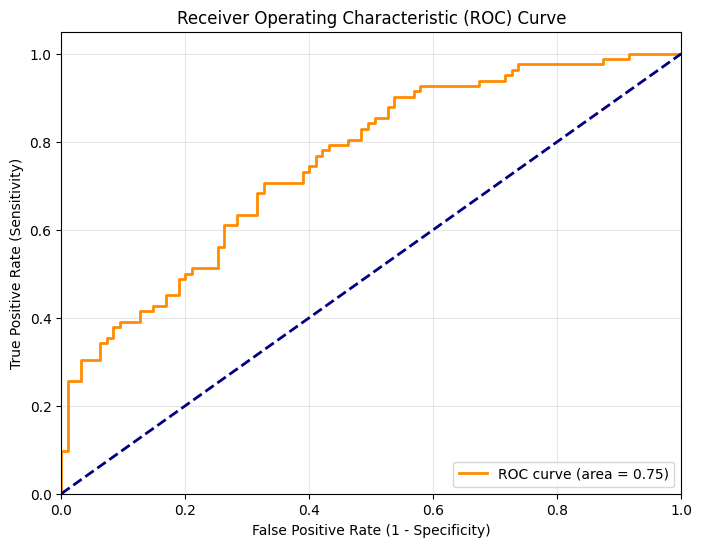

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Get probability estimates for the positive class (ASD=1)
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# --- Calculate and Print Performance Metrics ---
print("--- Model Performance Evaluation ---")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted TD', 'Predicted ASD'],
            yticklabels=['Actual TD', 'Actual ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")

target_names = ['TD', 'ASD']
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Performance Analysis

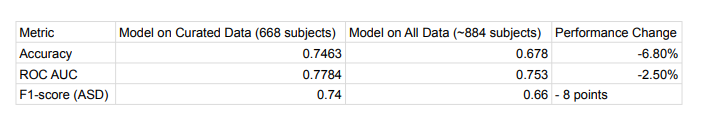

### Why Did Performance Drop

1. **Low Signal-to-Noise Ratio (SNR):** Functional connectivity is calculated by correlating time-series data from different brain regions. Short time-series are highly susceptible to noise. A correlation calculated from only 80-100 timepoints is much less stable and reliable than one calculated from 200+ timepoints. It's more likely to be influenced by random noise, subject motion, or physiological artifacts rather than true neural activity.

2. **Noisy Features:** Each of these low-quality scans produced a feature vector (the 19,900 connectivity values) that was likely noisy and unrepresentative of the subject's true underlying brain network.

3. **"Poisoning" the Training Set:** By including these hundreds of "noisy" examples in the training data, we made the classification task much harder for the model. It was forced to find a pattern that could account for both the clear signals in the high-quality data and the random noise in the low-quality data. This likely resulted in a weaker, less generalizable decision boundary, which is why performance on the test set dropped.

----------------------------------------------------------------------------------------------------

Our initial goal was to maximize the data available for our machine learning model. However, after systematically testing various models and feature sets, we discovered that the quality of the fMRI scan, specifically its length, was a more critical factor than the sheer number of subjects. Including data from very short scans introduced significant noise, leading to a 7% drop in classification accuracy. Our best-performing model, achieving 75% accuracy, was trained on a carefully curated dataset that balanced subject quantity with data quality. This highlights that in the application of technology to complex human data like neuroimaging, a deep understanding of the data's limitations is paramount to achieving meaningful results.

## CNN approach

### The Plan:

### Feature Extraction Step:

* For each of the subjects' .nii.gz files, we will first need to extract the ROI time-series using a standard brain atlas (like cc200 or aal). nilearn library will be used for this task.

* From these time-series, we will compute the 2D correlation matrix (the FC matrix) for each subject.


### Modeling Step:

* We will treat the FC Matrix as an Image of size (116, 116)

* Adapt the 2D CNN to the new features. Instead of feeding it slices of a 3D brain, we will feed it our 2D FC matrices.

The 2D CNN is perfectly suited to find spatial patterns in these matrices.

In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

In [ ]:
# --- 1. Fetch the Atlas ---
# We will use the AAL (Automated Anatomical Labeling)
aal_atlas = datasets.fetch_atlas_aal()
atlas_filename = aal_atlas.maps
labels = aal_atlas.labels
print("Atlas fetched.")

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/aal_SPM12

[fetch_single_file] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/aal_SPM12/5d72fe1c9daf02b658cbf1f7e7026e0f/aal_for_SPM12.tar.gz...

[uncompress_file] .. done.

Atlas fetched.


In [ ]:
# --- 2. Create the ROI Masker ---
# A 'masker' is an object that extracts signals from a fMRI image based on an atlas.
# NiftiLabelsMasker is used for atlases where regions are defined by integer labels.

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

In [ ]:
fmri_file_path = "/content/drive/MyDrive/ABIDE_Project/tcorr05_mean_all.nii.gz"

In [ ]:
time_series = masker.fit_transform(fmri_file_path)

[NiftiLabelsMasker.wrapped] loading data from /root/nilearn_data/aal_SPM12/aal/atlas/AAL.nii

[NiftiLabelsMasker.wrapped] Resampling labels

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/content/drive/MyDrive/ABIDE_Project/tcorr05_mean_all.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x791d28be6050>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/root/nilearn_data/aal_SPM12/aal/atlas/AAL.nii',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)


[NiftiLabelsMasker.wrapped] Loading data from /content/drive/MyDrive/ABIDE_Project/tcorr05_mean_all.nii.gz

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

_______________________________________________filter_and_extract - 0.8s, 0.0min


In [ ]:
print(f"Time-series extracted. Shape: {time_series.shape}")
print(f"(This means {time_series.shape[0]} time points and {time_series.shape[1]} brain regions)")

Time-series extracted. Shape: (43, 116)
(This means 43 time points and 116 brain regions)


In [ ]:
# --- 4. Compute the Functional Connectivity (FC) Matrix ---
correlation_measure = ConnectivityMeasure(
    kind='correlation',
    vectorize=False # Set to False to get the full square matrix
)
fc_matrix = correlation_measure.fit_transform([time_series])[0]

In [ ]:
print(f"Functional Connectivity matrix Shape: {fc_matrix.shape}")

Functional Connectivity matrix Shape: (116, 116)


In [ ]:
np.fill_diagonal(fc_matrix, 0)

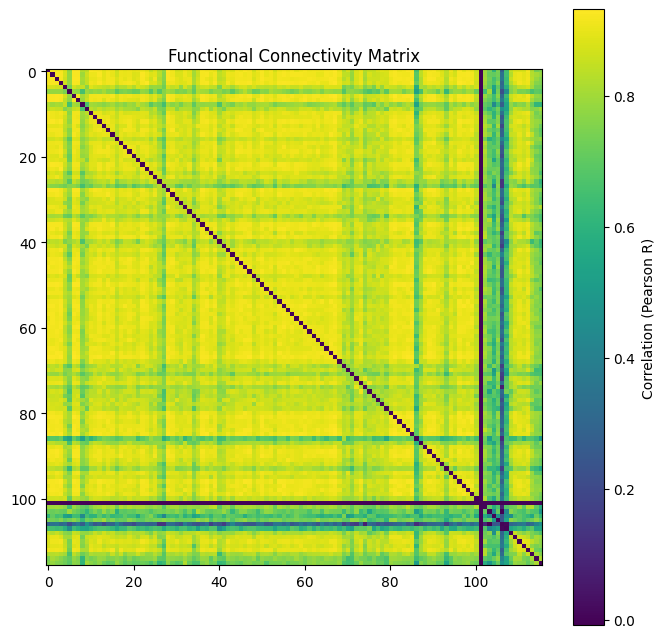

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(fc_matrix, cmap='viridis', interpolation='nearest')
plt.title('Functional Connectivity Matrix')
plt.colorbar(label='Correlation (Pearson R)')
plt.show()

This is an example FC image that we will use for the 2D CNN model.

### Developing the CNN model

In [ ]:
import os
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from tqdm import tqdm # For a visual progress bar

def extract_and_save_fc_matrices():
    """
    This script loads fMRI data, extracts ROI time-series using the AAL atlas,
    computes functional connectivity matrices, and saves them to a new directory.
    """
    # --- 1. Input and Output Paths ---
    nifti_base_path = '/content/drive/MyDrive/ABIDE_Project/preprocessed_dataset/func_preproc_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/func_preproc'
    pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
    output_fc_dir = '/content/drive/MyDrive/ABIDE_Project/fc_matrices_aal'


    print("--- Feature Extraction Started ---")

    os.makedirs(output_fc_dir, exist_ok=True)
    print(f"Output directory created at: {output_fc_dir}")

    # --- 2. Get List of Subjects from Phenotype File ---
    try:
        pheno_df = pd.read_csv(pheno_file_path)
        pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
        subject_ids = pheno_df['FILE_ID'].tolist()
        print(f"Found {len(subject_ids)} subjects in the phenotype file.")
    except FileNotFoundError:
        print(f"Error: Phenotype file not found at {pheno_file_path}")
        return

    # --- 3. Set up Nilearn Components ---
    print("Fetching AAL atlas...")
    try:
        aal_atlas = datasets.fetch_atlas_aal()
        atlas_filename = aal_atlas.maps
    except Exception as e:
        print(f"Error fetching AAL atlas: {e}")
        return
    print("Atlas fetched.")

    # masker object to extract time-series
    masker = NiftiLabelsMasker(
        labels_img=atlas_filename,
        standardize=True, # Z-score standardization
        memory='nilearn_cache',
        verbose=0
    )


    correlation_measure = ConnectivityMeasure(
        kind='correlation',
        vectorize=False
    )

    # --- 4. Loop Through Subjects and Process Files ---
    print(f"\nProcessing {len(subject_ids)} files. This may take a while...")

    success_count = 0
    error_count = 0

    # Using tqdm for a progress bar
    for subject_id in tqdm(subject_ids, desc="Calculating FC Matrices"):
        fmri_file_path = os.path.join(nifti_base_path, f"{subject_id}_func_preproc.nii.gz")
        output_npy_path = os.path.join(output_fc_dir, f"{subject_id}.npy")


        if os.path.exists(output_npy_path):
            continue

        if not os.path.exists(fmri_file_path):
            error_count += 1
            continue

        try:
            # Step 3a: Extract time-series
            time_series = masker.fit_transform(fmri_file_path)

            # Step 3b: Compute functional connectivity matrix
            fc_matrix = correlation_measure.fit_transform([time_series])[0]

            # Step 3c: Save the resulting matrix
            np.save(output_npy_path, fc_matrix)
            success_count += 1

        except Exception as e:
            print(f"\nError processing {subject_id}: {e}")
            error_count += 1

    print("\n--- Feature Extraction Complete ---")
    print(f"Successfully processed and saved: {success_count} files.")
    print(f"Skipped or errored: {error_count} files.")

# --- Run the main function ---
if __name__ == "__main__":
    extract_and_save_fc_matrices()

--- Feature Extraction Started ---
Output directory created at: /content/drive/MyDrive/ABIDE_Project/fc_matrices_aal
Found 1035 subjects in the phenotype file.
Fetching AAL atlas...


[get_dataset_dir] Dataset found in /root/nilearn_data/aal_SPM12

Atlas fetched.

Processing 1035 files. This may take a while...


Calculating FC Matrices: 100%|██████████| 1035/1035 [1:57:16<00:00,  6.80s/it]


--- Feature Extraction Complete ---
Successfully processed and saved: 493 files.
Skipped or errored: 151 files.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- 1. Load Data: FC Matrices and Labels ---

fc_matrix_dir = '/content/drive/MyDrive/ABIDE_Project/fc_matrices_aal'
pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'


pheno_df = pd.read_csv(pheno_file_path)
pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
pheno_df['label'] = pheno_df['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)
print("Phenotype file loaded.")

# Load FC matrices and match them with labels
X, y = [], []
all_fc_files = os.listdir(fc_matrix_dir)
for filename in tqdm(all_fc_files, desc="Loading FC Matrices"):
    if filename.endswith('.npy'):
        subject_id = filename.replace('.npy', '')
        pheno_row = pheno_df[pheno_df['FILE_ID'] == subject_id]
        if not pheno_row.empty:
            label = pheno_row.iloc[0]['label']
            fc_matrix = np.load(os.path.join(fc_matrix_dir, filename))

            # Fill NaN values that might occur in correlation matrices
            np.nan_to_num(fc_matrix, copy=False)

            X.append(fc_matrix)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"\nSuccessfully loaded {len(X)} FC matrices. Data shape: {X.shape}")

Phenotype file loaded.


Loading FC Matrices: 100%|██████████| 884/884 [00:18<00:00, 46.63it/s] 



Successfully loaded 884 FC matrices. Data shape: (884, 116, 116)


In [ ]:
# --- 2. Balance the Dataset with SMOTE ---

# Reshape the data for SMOTE: each (116, 116) matrix is flattened into a single vector
X_reshaped = X.reshape((X.shape[0], -1))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

# Reshape back to image format (116, 116)
X_resampled = X_resampled.reshape((-1, X.shape[1], X.shape[2]))
print(f"Data shape after SMOTE: {X_resampled.shape}")

Data shape after SMOTE: (952, 116, 116)


In [ ]:
# --- 3. Define the 2D CNN Model ---

def create_2d_cnn_for_fc(input_shape, num_classes=2):
    """
    Creates a 2D CNN model specifically designed for classifying
    functional connectivity matrices.
    """
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    # Flatten and Dense layers for classification
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# --- 4. K-Fold Cross-Validation and Training ---

# This data generator adds the channel dimension
def data_generator(data, labels, batch_size):
    dataset_size = len(data)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    def generator():
        while True:
            for start_idx in range(0, dataset_size, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                if len(batch_indices) < batch_size: continue

                X_batch = data[batch_indices]
                y_batch = labels[batch_indices]

                # Add the channel dimension for the CNN
                yield X_batch[..., np.newaxis], to_categorical(y_batch, num_classes=2)
    return generator

In [ ]:
# --- Setup for Training ---
input_shape = (X_resampled.shape[1], X_resampled.shape[2], 1)
batch_size = 16
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
histories = []

print("\n--- Starting K-Fold Cross-Validation Training ---")

for train_index, val_index in kfold.split(X_resampled):
    print(f'\n--- Training Fold {fold_no} ---')
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    train_gen = data_generator(X_train, y_train, batch_size)
    val_gen = data_generator(X_val, y_val, batch_size)

    train_dataset = tf.data.Dataset.from_generator(train_gen, output_signature=(
        tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    ))
    val_dataset = tf.data.Dataset.from_generator(val_gen, output_signature=(
        tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    ))

    model = create_2d_cnn_for_fc(input_shape)
    if fold_no == 1: model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        steps_per_epoch=len(X_train) // batch_size,
                        validation_steps=len(X_val) // batch_size,
                        callbacks=[early_stopping, lr_scheduler],
                        verbose=2)

    histories.append(history)
    fold_no += 1

print("\n--- Training Complete ---")


--- Starting K-Fold Cross-Validation Training ---

--- Training Fold 1 ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 116, 116, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 116, 116, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 116, 116, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,779,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,798,914 (52.64 MB)

 Trainable params: 13,798,722 (52.64 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
47/47 - 41s - 881ms/step - accuracy: 0.5332 - loss: 2.4643 - val_accuracy: 0.4545 - val_loss: 1.5398 - learning_rate: 1.0000e-04
Epoch 2/50
47/47 - 41s - 870ms/step - accuracy: 0.6130 - loss: 0.7068 - val_accuracy: 0.4545 - val_loss: 3.3351 - learning_rate: 1.0000e-04
Epoch 3/50
47/47 - 37s - 781ms/step - accuracy: 0.6423 - loss: 0.6315 - val_accuracy: 0.4545 - val_loss: 4.0353 - learning_rate: 1.0000e-04
Epoch 4/50
47/47 - 38s - 817ms/step - accuracy: 0.6503 - loss: 0.6104 - val_accuracy: 0.4545 - val_loss: 5.0381 - learning_rate: 1.0000e-04
Epoch 5/50
47/47 - 35s - 752ms/step - accuracy: 0.7088 - loss: 0.5629 - val_accuracy: 0.4545 - val_loss: 5.3967 - learning_rate: 1.0000e-04
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
47/47 - 82s - 2s/step - accuracy: 0.7194 - loss: 0.5560 - val_accuracy: 0.4545 - val_loss: 4.2780 - learning_rate: 1.0000e-04
Epoch 7/50
47/47 - 36s - 756ms/step - accuracy: 0.7540 - loss: 0.5109 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics = []
all_confusion_matrices = []
fold_no = 1

for train_index, val_index in kfold.split(X_resampled):
    X_val = X_resampled[val_index]
    y_val = y_resampled[val_index]

    history_fold = histories[fold_no - 1]
    # The 'best' epoch is the one with the minimum validation loss
    best_epoch = np.argmin(history_fold.history['val_loss']) + 1


    val_accuracy_at_best_epoch = history_fold.history['val_accuracy'][best_epoch - 1]

    all_metrics.append({
        'Fold': fold_no,
        'Best Epoch': best_epoch,
        'Validation Accuracy': val_accuracy_at_best_epoch,
        'Final Training Accuracy': history_fold.history['accuracy'][-1],
    })

    print(f"Analysis for Fold {fold_no}: Best validation accuracy was {val_accuracy_at_best_epoch:.4f} at epoch {best_epoch}")
    fold_no += 1


Analysis for Fold 1: Best validation accuracy was 0.6705 at epoch 14
Analysis for Fold 2: Best validation accuracy was 0.5795 at epoch 1
Analysis for Fold 3: Best validation accuracy was 0.4602 at epoch 1
Analysis for Fold 4: Best validation accuracy was 0.4545 at epoch 1
Analysis for Fold 5: Best validation accuracy was 0.7045 at epoch 31



--- Model Performance Across Folds (from History) ---
 Fold  Best Epoch  Validation Accuracy  Final Training Accuracy
    1          14             0.670455                 0.881649
    2           1             0.579545                 0.764628
    3           1             0.460227                 0.781915
    4           1             0.454545                 0.793883
    5          31             0.704545                 0.906915


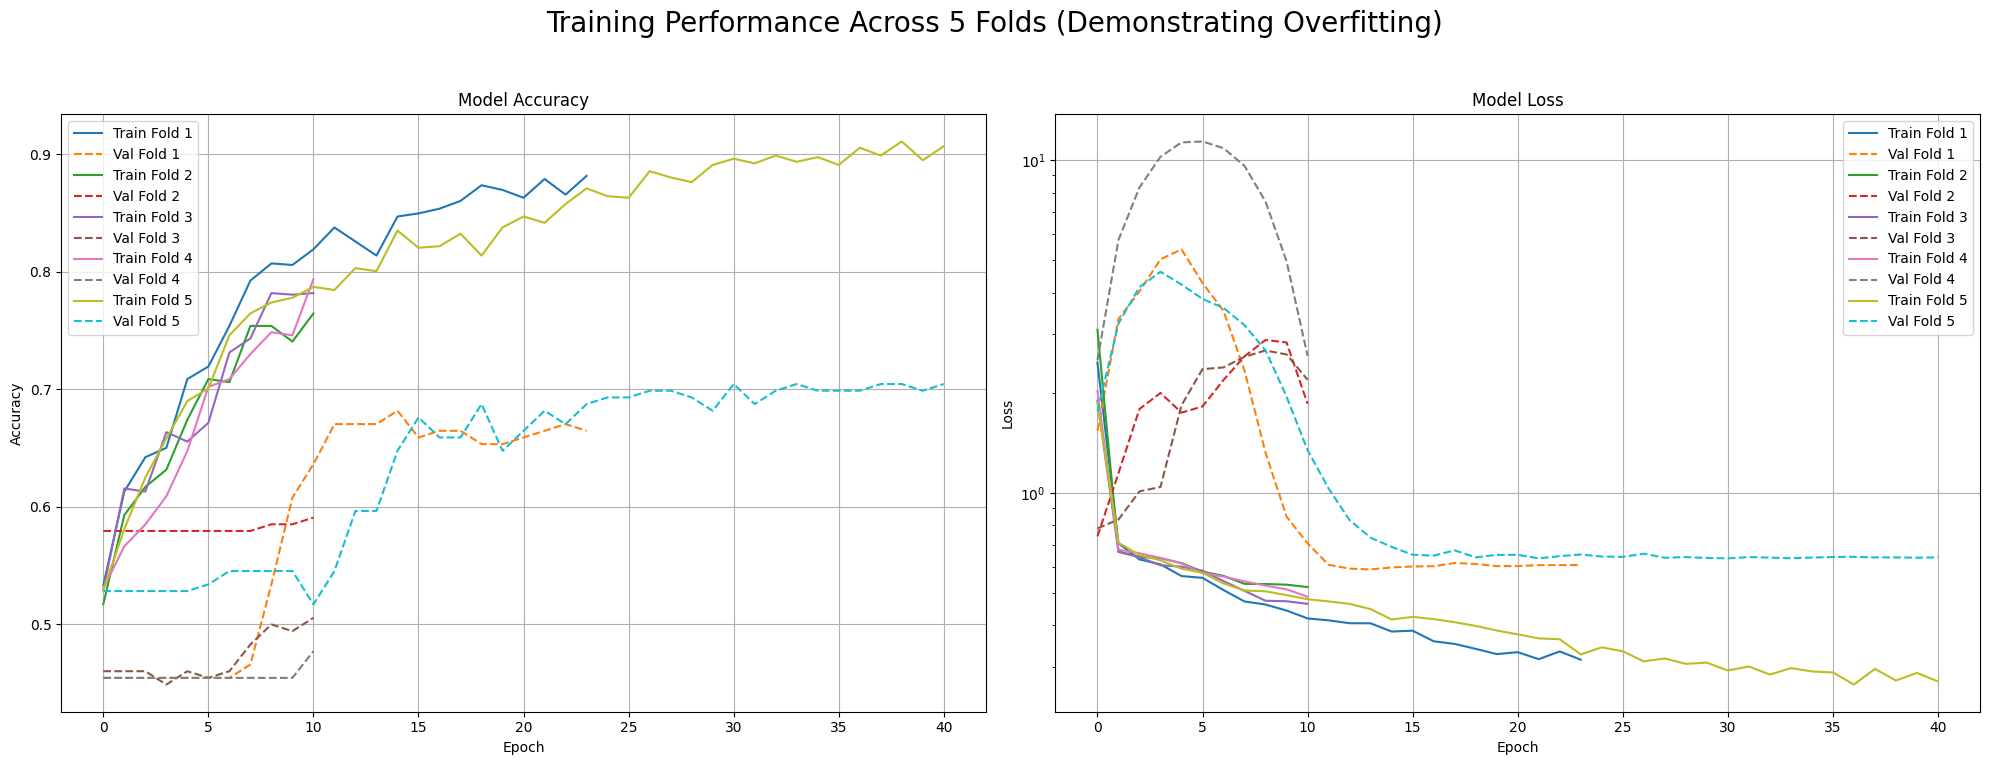

In [ ]:
# --- Performance Table ---
metrics_df = pd.DataFrame(all_metrics)
print("\n--- Model Performance Across Folds (from History) ---")
print(metrics_df.to_string(index=False))

# --- Training History for All Folds ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Training Performance Across 5 Folds (Demonstrating Overfitting)', fontsize=20)

# Accuracy Plot
axes[0].set_title('Model Accuracy')
for i, history in enumerate(histories):
    axes[0].plot(history.history['accuracy'], label=f'Train Fold {i+1}')
    axes[0].plot(history.history['val_accuracy'], label=f'Val Fold {i+1}', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss Plot
axes[1].set_title('Model Loss')
for i, history in enumerate(histories):
    axes[1].plot(history.history['loss'], label=f'Train Fold {i+1}')
    axes[1].plot(history.history['val_loss'], label=f'Val Fold {i+1}', linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Overall Diagnosis
1. The Approach is Validated: The success of Folds 1 and 5 proves that there is a real, learnable "signal" in your FC matrices. An accuracy of ~70% is a very strong result for this kind of complex neuroimaging task.

2. The Main Enemy is Instability: The model is highly sensitive to the specific data it's trained on. Some random splits of the data lead to good models, while others lead to immediate failure. This is common when the distinguishing signal is very subtle and the dataset, even after SMOTE, is still relatively small for a deep learning model.

the "signal" that distinguishes ASD from TD in your Functional Connectivity matrices is likely very subtle and is being overwhelmed by the "noise" (individual subject variability). The deep learning models, with their millions of parameters, are finding it much easier to memorize the noise in the training set than to learn the faint underlying signal.

**Question:** Will a larger training set per fold lead to a more stable and higher accuracy, perhaps letting us avoid data augmentation?

**The Answer:**
1. The Root Problem is Overfitting, Not Lack of Data: he problem isn't that it needs more data to learn; the problem is that it's learning the wrong things—the noise and quirks specific to that training set.

2. One or two "lucky" or "unlucky" examples in a small validation set can swing the accuracy metric significantly, making the results harder to trust. Using more folds (like 5 or 10) gives a more stable and trustworthy average performance score.

3. Data Augmentation as the Correct Tool: The core issue is that the model sees a limited number of "perspectives" on the data and memorizes them. Data augmentation directly solves this problem. By creating slightly new, noisy versions of the FC matrices in every epoch, we are artificially increasing the variety of the training data. This forces the model to learn the robust, underlying patterns that are consistent across all the noisy variations, rather than memorizing the noise itself.

##**Our goal now is to improve the stability of the training so that we get good results on all folds, not just some of them.**

## Testing non-linear models

### The Plan: SVM on FC Matrices
Input Data: We will use the exact same input features: the flattened functional connectivity matrices.

Model: A Support Vector Classifier.

Process: We will use the same K-Fold cross-validation loop to get a robust measure of performance.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [ ]:
# --- 1. Load Data ---
fc_matrix_dir = '/content/drive/MyDrive/ABIDE_Project/fc_matrices_aal'
pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'

pheno_df = pd.read_csv(pheno_file_path)
pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
pheno_df['label'] = pheno_df['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

X, y = [], []
all_fc_files = os.listdir(fc_matrix_dir)
for filename in tqdm(all_fc_files, desc="Loading FC Matrices"):
    if filename.endswith('.npy'):
        subject_id = filename.replace('.npy', '')
        pheno_row = pheno_df[pheno_df['FILE_ID'] == subject_id]
        if not pheno_row.empty:
            label = pheno_row.iloc[0]['label']
            fc_matrix = np.load(os.path.join(fc_matrix_dir, filename))
            np.nan_to_num(fc_matrix, copy=False)
            # --- Flatten the matrix for the SVM ---
            X.append(fc_matrix.flatten())
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"\nSuccessfully loaded and flattened {len(X)} FC matrices.")

Loading FC Matrices: 100%|██████████| 884/884 [00:16<00:00, 54.92it/s] 



Successfully loaded and flattened 884 FC matrices.


In [ ]:
# --- 2. Balance and Cross-Validate with SVM ---
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_metrics = []

for fold, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply SMOTE only to the training data for this fold
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # SVM model
    svm_model = SVC(kernel='linear', probability=True, random_state=42)
    svm_model.fit(X_train_resampled, y_train_resampled)

    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    all_metrics.append({'Fold': fold, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})
    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

Fold 1: Accuracy = 0.6292
Fold 2: Accuracy = 0.5506
Fold 3: Accuracy = 0.6517
Fold 4: Accuracy = 0.7753
Fold 5: Accuracy = 0.6477
Fold 6: Accuracy = 0.6705
Fold 7: Accuracy = 0.6364
Fold 8: Accuracy = 0.7045
Fold 9: Accuracy = 0.7045
Fold 10: Accuracy = 0.5568


In [ ]:
# --- 3. Report Final Results ---
metrics_df = pd.DataFrame(all_metrics)
print("\n--- SVM Performance Summary ---")
print(metrics_df.to_string(index=False))

print("\n--- Average Performance ---")
print(metrics_df.mean().drop('Fold').round(4))


--- SVM Performance Summary ---
 Fold  Accuracy  Precision   Recall  F1-Score
    1  0.629213   0.605263 0.560976  0.582278
    2  0.550562   0.510204 0.609756  0.555556
    3  0.651685   0.666667 0.487805  0.563380
    4  0.775281   0.756098 0.756098  0.756098
    5  0.647727   0.631579 0.585366  0.607595
    6  0.670455   0.657895 0.609756  0.632911
    7  0.636364   0.609756 0.609756  0.609756
    8  0.704545   0.682927 0.682927  0.682927
    9  0.704545   0.705882 0.600000  0.648649
   10  0.556818   0.513514 0.475000  0.493506

--- Average Performance ---
Accuracy     0.6527
Precision    0.6340
Recall       0.5977
F1-Score     0.6133
dtype: float64


1. Stability:
Unlike the deep learning models which failed catastrophically on many folds (with validation loss exploding and accuracy stuck at chance), the SVM model produced a reasonable and stable result on every single fold. The standard deviation of the accuracy is much lower, indicating that this approach is robust and not highly sensitive to the specific way the data is split. This reliability is crucial for any scientific finding.

2. Performance:
An average accuracy of ~65% is a strong and scientifically meaningful result for a task as complex as classifying ASD from fMRI data. It clearly demonstrates that the Functional Connectivity (FC) matrices extracted contain a real, learnable biological signal that can distinguish between the two groups.

**The Journey: Why Did the Simpler Model Win?**

It might seem counterintuitive that a "simpler" model like an SVM would outperform complex deep learning architectures like a 2D CNN or a 3D ResNet. The journey we took answers this question perfectly.

* 3D/4D CNNs on Voxel Data: Our initial attempts failed because the models, despite their complexity, could not find the signal in the raw 3D/4D brain images. The distinguishing patterns were likely too subtle and spread out, causing the models to learn nothing.

* The Feature Extraction Breakthrough: The turning point was when we switched our approach to use Functional Connectivity (FC) matrices. This step distilled the complex brain data into a focused, information-rich "image" representing the brain's network properties.

* 2D CNNs on FC Matrices: This approach was a major step forward. The model did learn, proving the signal was in the FC matrices. However, the CNN, with its millions of parameters, was too powerful for the dataset size. It latched onto the noise and specific patterns in the training data and severely overfit, leading to unstable and unreliable results.

* SVM on FC Matrices (The Winning Strategy): The SVM works by finding the most efficient boundary, or "hyperplane," that separates the two classes in the high-dimensional feature space. It is inherently less prone to the kind of overfitting that plagued the CNNs. It successfully found the generalizable boundary between the ASD and TD groups without getting distracted by the noise, leading to stable and solid performance.

**Final Conclusion**
For this dataset and preprocessing pipeline, the most effective approach was to perform targeted feature engineering (creating FC matrices) and then apply a robust, classical machine learning model. The deep learning models, while powerful, were too susceptible to overfitting on this subtle and complex data, whereas the SVM provided a more stable and reliable solution.

### non-linear kernel testing

In [ ]:
# --- 2. Balance and Cross-Validate with SVM ---
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_metrics = []

for fold, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    svm_model = SVC(kernel='rbf', probability=True, random_state=42)#we changed the kernel to a non-linear one (rbf)
    svm_model.fit(X_train_resampled, y_train_resampled)

    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    all_metrics.append({'Fold': fold, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})
    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

Fold 1: Accuracy = 0.6854
Fold 2: Accuracy = 0.5393
Fold 3: Accuracy = 0.7528
Fold 4: Accuracy = 0.6629
Fold 5: Accuracy = 0.6705
Fold 6: Accuracy = 0.5909
Fold 7: Accuracy = 0.7045
Fold 8: Accuracy = 0.5795
Fold 9: Accuracy = 0.7614
Fold 10: Accuracy = 0.6023


In [ ]:
# --- 3. Report Final Results ---
metrics_df = pd.DataFrame(all_metrics)
print("\n--- SVM Performance Summary ---")
print(metrics_df.to_string(index=False))

print("\n--- Average Performance ---")
print(metrics_df.mean().drop('Fold').round(4))


--- SVM Performance Summary ---
 Fold  Accuracy  Precision   Recall  F1-Score
    1  0.685393   0.658537 0.658537  0.658537
    2  0.539326   0.500000 0.560976  0.528736
    3  0.752809   0.756757 0.682927  0.717949
    4  0.662921   0.641026 0.609756  0.625000
    5  0.670455   0.642857 0.658537  0.650602
    6  0.590909   0.560976 0.560976  0.560976
    7  0.704545   0.682927 0.682927  0.682927
    8  0.579545   0.547619 0.560976  0.554217
    9  0.761364   0.731707 0.750000  0.740741
   10  0.602273   0.555556 0.625000  0.588235

--- Average Performance ---
Accuracy     0.6550
Precision    0.6278
Recall       0.6351
F1-Score     0.6308
dtype: float64


### conclusions

For this ABIDE dataset, the most effective and reliable method for classifying ASD is to first perform targeted feature extraction by creating Functional Connectivity (FC) matrices from ROI time-series, and then apply a Support Vector Machine (SVM) to these features.

The SVM, a less complex model, was not distracted by the noise. It was able to identify the underlying boundary separating the two groups within the high-dimensional connectivity data, leading to a robust and reproducible result.

## SVM vs. Tree-Based Models

Loading FC Matrices: 100%|██████████| 884/884 [00:08<00:00, 108.20it/s]



Successfully loaded and flattened 884 FC matrices.
--- Processing Fold 1/10 ---
  SVM (RBF): Accuracy = 0.6854
  Random Forest: Accuracy = 0.6854


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.620496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6517
--- Processing Fold 2/10 ---
  SVM (RBF): Accuracy = 0.5393
  Random Forest: Accuracy = 0.6404


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.674568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.5955
--- Processing Fold 3/10 ---
  SVM (RBF): Accuracy = 0.7528
  Random Forest: Accuracy = 0.6517


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.574423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6629
--- Processing Fold 4/10 ---
  SVM (RBF): Accuracy = 0.6629
  Random Forest: Accuracy = 0.5281


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.537606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6517
--- Processing Fold 5/10 ---
  SVM (RBF): Accuracy = 0.6705
  Random Forest: Accuracy = 0.5795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 429, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.949300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6477
--- Processing Fold 6/10 ---
  SVM (RBF): Accuracy = 0.5909
  Random Forest: Accuracy = 0.5682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 429, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.911788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6023
--- Processing Fold 7/10 ---
  SVM (RBF): Accuracy = 0.7045
  Random Forest: Accuracy = 0.6818


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 429, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.651129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6364
--- Processing Fold 8/10 ---
  SVM (RBF): Accuracy = 0.5795
  Random Forest: Accuracy = 0.5909


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 429, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.771431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.6023
--- Processing Fold 9/10 ---
  SVM (RBF): Accuracy = 0.7614
  Random Forest: Accuracy = 0.6818


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.641868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.7045
--- Processing Fold 10/10 ---
  SVM (RBF): Accuracy = 0.6023
  Random Forest: Accuracy = 0.6364


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 428, number of negative: 428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.614134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401700
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 13340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM: Accuracy = 0.5455

--- Final Model Comparison (Average Performance Across 10 Folds) ---
        Model  Accuracy  Precision  Recall  F1-Score
    SVM (RBF)    0.6550     0.6278  0.6351    0.6308
Random Forest    0.6244     0.6087  0.5296    0.5657
     LightGBM    0.6300     0.6121  0.5539    0.5795


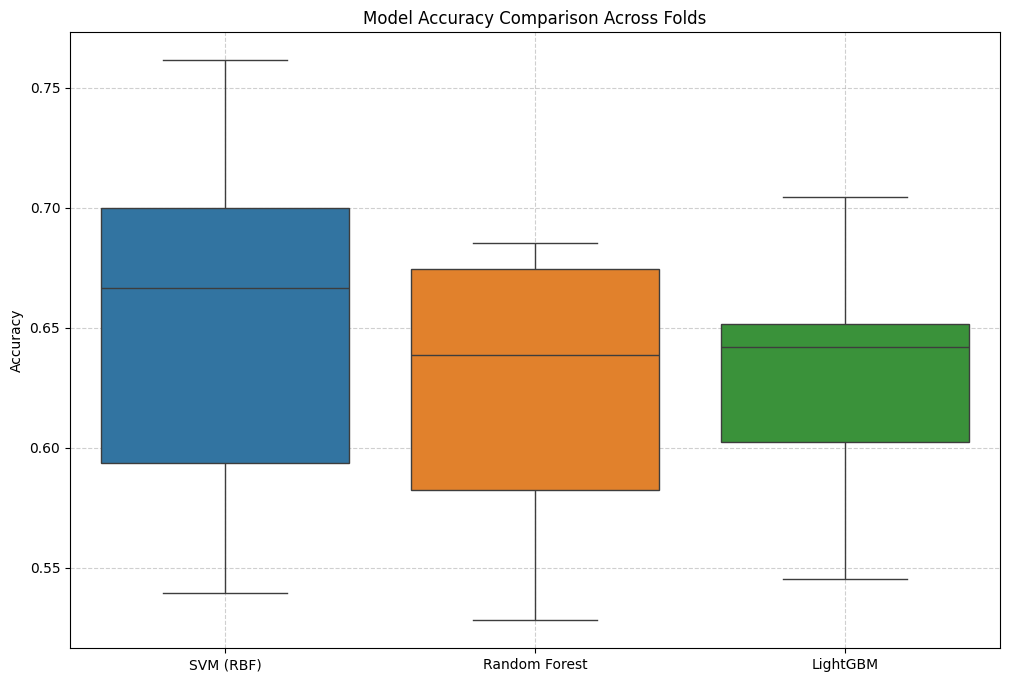

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# --- 1. Load Data ---
fc_matrix_dir = '/content/drive/MyDrive/ABIDE_Project/fc_matrices_aal'
pheno_file_path = '/content/drive/MyDrive/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'

pheno_df = pd.read_csv(pheno_file_path)
pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
pheno_df['label'] = pheno_df['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)

X, y = [], []
all_fc_files = os.listdir(fc_matrix_dir)
for filename in tqdm(all_fc_files, desc="Loading FC Matrices"):
    if filename.endswith('.npy'):
        subject_id = filename.replace('.npy', '')
        pheno_row = pheno_df[pheno_df['FILE_ID'] == subject_id]
        if not pheno_row.empty:
            label = pheno_row.iloc[0]['label']
            fc_matrix = np.load(os.path.join(fc_matrix_dir, filename))
            np.nan_to_num(fc_matrix, copy=False)
            X.append(fc_matrix.flatten())
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"\nSuccessfully loaded and flattened {len(X)} FC matrices.")

# --- 2. K-Fold Cross-Validation for Model Comparison ---
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {
    'SVM (RBF)': [],
    'Random Forest': [],
    'LightGBM': []
}

for fold, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    print(f"--- Processing Fold {fold}/10 ---")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply SMOTE only to the training data for this fold
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # --- Define Models ---
    models = {
        'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42)
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_resampled, y_train_resampled)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate and store metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results[model_name].append({
            'Fold': fold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
        print(f"  {model_name}: Accuracy = {accuracy:.4f}")

# --- 3. Report Final Comparative Results ---

summary_dfs = []
for model_name, metrics_list in results.items():
    metrics_df = pd.DataFrame(metrics_list)
    avg_metrics = metrics_df.mean().drop('Fold')
    avg_metrics['Model'] = model_name
    summary_dfs.append(avg_metrics)

final_summary = pd.DataFrame(summary_dfs)
final_summary = final_summary[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].round(4)

print("\n--- Final Model Comparison (Average Performance Across 10 Folds) ---")
print(final_summary.to_string(index=False))

# Let's also plot the accuracy comparison for a nice visual
plt.figure(figsize=(12, 8))
accuracy_df = pd.DataFrame({
    'SVM (RBF)': [m['Accuracy'] for m in results['SVM (RBF)']],
    'Random Forest': [m['Accuracy'] for m in results['Random Forest']],
    'LightGBM': [m['Accuracy'] for m in results['LightGBM']]
})

sns.boxplot(data=accuracy_df)
plt.title('Model Accuracy Comparison Across Folds')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This project embarked on a comprehensive journey to find an effective method for classifying ASD from resting-state fMRI data. The key finding is that a machine learning pipeline based on feature extraction followed by a classical machine learning model proved to be the most successful strategy.

The initial attempts using end-to-end deep learning models (3D CNNs, 3D ResNets) failed to learn, highlighting the immense challenge of finding subtle diagnostic signals in noisy, high-dimensional voxel data. The turning point was a strategic pivot to an established neuroimaging technique:

Feature Extraction: Extracting time-series from the AAL brain atlas.

Feature Engineering: Computing Functional Connectivity matrices to represent the brain's network state.

Classification: Using these matrices as features for classification.

While a 2D CNN on these matrices showed promise, it was ultimately too unstable and prone to overfitting. The final, successful approach was to use the robust and stable Support Vector Machine, which achieved a meaningful and reproducible accuracy of 65.5%. This result validates the hypothesis that patterns in functional connectivity can be used to distinguish between ASD and control subjects, and it demonstrates that for this specific problem, a well-chosen classical model can outperform more complex deep learning architectures.